# Identifying key milestones

This section aims to reproduce the `key splitting milestone identification` approach
presented in the work of Hlosta et al. {cite}`hlosta_kocvara_Zdrahal_2019`

**Keywords**: Identifying at-risk students

The approach of Hlosta et al. aims to detect points in time where the paths of
successful and unsuccessful students start to split.

**Procedure:**

1. Define key performance metrics for students
   (e.g., number of clicks, assessment scores) and model them as a time series for
   each student. (e.g., the
   [cumulative number of clicks](#cumulative-number-of-clicks),
   cumulative assessment scores,
   [cumulative weighted assessments scores](#cumulative-weighted-assessments-scores))
2. Perform statistical tests (e.g., Unpaired t-test, Wilcoxon Rank Sum Test) in each
   time slice between different groups of students.
   (e.g., failing student group, succeeding student group)
3. Compute the splitting value in each time slice that minimizes the split error.
   (i.e., that maximizes prediction accuracy)
4. Plot the time-series graph showing at which time slice the first statistically
   significant difference was detected and the split values.

```{bibliography}
:filter: docname in docnames
```

In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.stats import levene, norm, probplot, ranksums, shapiro

from oulad import get_oulad

oulad = get_oulad()

## Cumulative weighted assessments scores

We use the weighted assessment score for the key performance metric, in this example.

### Step 1: Model the metric as a time series for each student

As in the work of Hlosta et al. we will use the `EEE/2014J` course.

```{note}
During merging, we loose 253 students that didn't submit any assessments.
```

In [2]:
cumulative_weighted_assessment_score = (
    oulad.student_registration[
        (oulad.student_registration.code_module == "EEE")
        & (oulad.student_registration.code_presentation == "2014J")
    ][["id_student"]]
    .merge(
        oulad.student_assessment.drop(["date_submitted", "is_banked"], axis=1),
        how="inner",
        on="id_student",
    )
    .merge(
        oulad.assessments[
            (oulad.assessments.code_module == "EEE")
            & (oulad.assessments.code_presentation == "2014J")
        ],
        how="inner",
        on="id_assessment",
    )
    .assign(weighted_score=lambda x: x["score"] * x["weight"] / 100)[
        ["date", "id_student", "weighted_score"]
    ]
    .pivot(index="date", columns="id_student", values="weighted_score")
    .fillna(0)
    .cumsum()
    .T.join(
        oulad.student_info[
            (oulad.student_info.code_module == "EEE")
            & (oulad.student_info.code_presentation == "2014J")
        ][["id_student", "final_result"]].set_index("id_student")
    )
    .set_index("final_result", append=True)
)

unstacked_cumulative_weighted_assessment_score = (
    cumulative_weighted_assessment_score.unstack()
)

display(cumulative_weighted_assessment_score)

,,33.0,68.0,131.0,166.0
id_student,final_result,,,,
47061,Pass,11.68,37.16,53.96,70.20
60809,Pass,14.56,36.40,60.48,86.80
62034,Pass,14.56,38.08,55.72,55.72
67539,Pass,12.00,33.84,48.40,64.92
67685,Pass,12.00,35.52,57.36,81.72
...,...,...,...,...,...
2654928,Pass,14.56,38.36,61.60,83.72
2663195,Pass,14.56,38.36,61.88,84.00
2681277,Withdrawn,15.20,15.20,15.20,15.20


### Step 2: Perform statistical tests

Let's first check whether we can use the Unpaired t-test.

#### Unpaired t-test

##### Assumptions

```{admonition} Spoilers
Assumptions fail for the t-test. We can skip to the [Wilcoxon rank-sum test](
#wilcoxon-rank-sum-test).
```

1. **Independence of the observations**
   - [X] Each student belongs to only one group (Distinction, Pass, Fail, Withdrawn).
   - [X] There is no relationship between students in each group. (We assume that the
         `final_result` of a student does not depend on the `final_result` of other
         students)
2. **Absence of outliers** (see [box plot](#detecting-outliers-visually) and [outlier
   count](#detecting-extreme-outliers-statistically) below)
3. **Normality** (each group should be normally distributed, see [Shapiro-Wilk test](
   #examine-normality-with-the-shapiro-wilk-test) below)
4. **Homoscedasticity** (homogeneity of variances - the variance within the groups
   should be similar, see
   [Levene test](#verifying-equal-variances-with-the-levene-test) below)

###### **Detecting outliers visually**

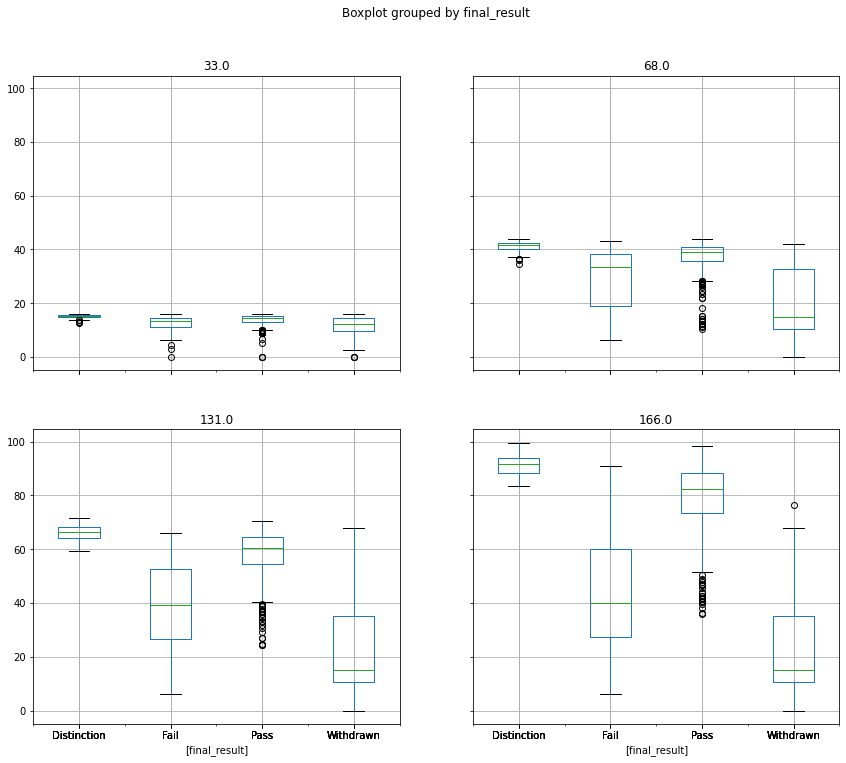

In [3]:
cumulative_weighted_assessment_score.boxplot(by="final_result", figsize=(14, 12))
plt.show()

We can see quite a few outliers, notably in the `Pass` student group.

###### **Detecting extreme outliers statistically**

Let's verify whether there are any extreme outliers (above `Q3 + 3xIQR` or below
`Q1 - 3xIQR`).

A quick reminder:
 - **Q1** is the first quantile = the value that is greater than 25% of the data
 - **Q3** is the third quantile = the value that is greater than 75% of the data
 - **IQR** is the **Interquartile Range** = Q3 - Q1

In [4]:
extremes = (
    unstacked_cumulative_weighted_assessment_score.quantile([0.25, 0.75])
    .T.assign(IQR=lambda x: x[0.75] - x[0.25])
    .assign(
        lower_extreme=lambda x: x[0.25] - 3 * x["IQR"],
        upper_extreme=lambda x: x[0.75] + 3 * x["IQR"],
    )[["lower_extreme", "upper_extreme"]]
)

bigger = unstacked_cumulative_weighted_assessment_score > extremes.upper_extreme
smaller = unstacked_cumulative_weighted_assessment_score < extremes.lower_extreme
total = bigger.sum().sum() + smaller.sum().sum()

print(
    f"The number of extreme outliers (N={total}) represents "
    f"{100 * total / cumulative_weighted_assessment_score.count().sum():.2f}"
    f"% of the dataset (N={cumulative_weighted_assessment_score.count().sum()})"
)

The number of extreme outliers (N=21) represents 0.56% of the dataset (N=3740)


We suspect that the number of outliers might bias the test.
However, as their proportion is relatively small (0.56%) and the dataset is quite
large (3740), we assume that the impact of the bias will be limited.

###### **Examine normality visually**

Let's plot a histogram to inspect the distribution visually.

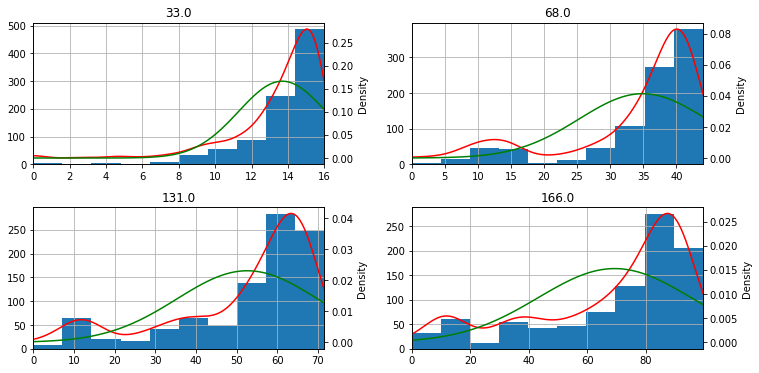

In [5]:
for arr in cumulative_weighted_assessment_score.hist(figsize=(12, 6)):
    for ax in arr:
        scores = cumulative_weighted_assessment_score[float(ax.title.get_text())]
        ax = ax.twinx()
        scores.plot(kind="kde", legend=False, ax=ax, color="red")
        ax.set_xlim(*scores.agg([np.min, np.max]).values)
        x = np.linspace(*ax.get_xlim(), 100)
        y = norm.pdf(
            x, **scores.agg([np.mean, np.std]).set_axis(["loc", "scale"]).to_dict()
        )
        ax.plot(x, y, color="green")

We notice that the shape of the distribution (blue histogram / red density) is quite
different from the normal bell curve (in green).

Another option might be to plot probability plots that show how much our
distributions follow the normal distribution.

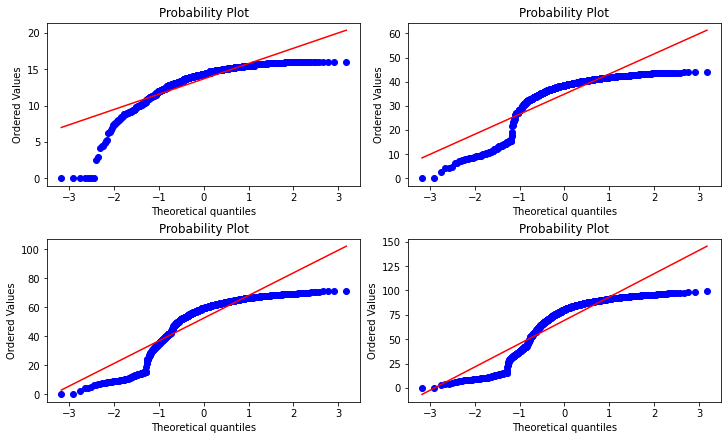

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), constrained_layout=True)
probplot(cumulative_weighted_assessment_score[33.0], dist="norm", plot=axes[0, 0])
probplot(cumulative_weighted_assessment_score[68.0], dist="norm", plot=axes[0, 1])
probplot(cumulative_weighted_assessment_score[131.0], dist="norm", plot=axes[1, 0])
probplot(cumulative_weighted_assessment_score[166.0], dist="norm", plot=axes[1, 1])
plt.show()

Here too, we notice that the distribution deviates from the theoretical quantiles
and thus seems to be not normal.

###### **Examine normality with the Shapiro-Wilk test**

The Shapiro-Wilk normality test tests the null hypothesis H0="the distribution is
normally distributed" against H1="the distribution is **not** normally distributed".

Thus, the null hypothesis is **rejected** if the p-value is **less or equal** to a
chosen alpha level which means that there is evidence that the tested data are **not**
normally distributed.

In [7]:
cumulative_weighted_assessment_score.agg(
    lambda x: shapiro(x).pvalue <= 0.05
).rename_axis("date").reset_index(name="H0 rejected")

,date,H0 rejected
0,33.0,True
1,68.0,True
2,131.0,True
3,166.0,True


The Shapiro-Wilk test indicates evidence that the distributions are
**not** normally distributed.

At this stage, we fail to satisfy the required assumptions for an
Unpaired t-test because the t-test requires normality to assure that the sample mean
is normal.

However, the dataset is large (3740), and thus the Central limit theorem applies,
which means that the sample mean will follow a normal distribution.

Thus, we assume that the normality requirement is satisfied in this case.

###### **Verifying equal variances with the Levene test**

Finally, let's test the homogeneity of variance using the Levene test.

The Levene test tests the null hypothesis H0="groups have equal variances" against
H1="the variances are different".

Thus, if the p-value is **less or equal** to a chosen alpha level, the null
hypothesis is **rejected**, and there is evidence that the group variances are
**different**.

In [8]:
cumulative_weighted_assessment_score.agg(
    lambda x: levene(*[row[~np.isnan(row)] for row in x.unstack().T.values]).pvalue
    <= 0.05
).rename_axis("date").reset_index(name="H0 rejected")

,date,H0 rejected
0,33.0,True
1,68.0,True
2,131.0,True
3,166.0,True


The Levene test indicates that there is evidence that the variances are **different**.

###### **Conclusion**

We conclude that assumptions for an Unpaired t-test are not satisfied as the variances
are different.

Let's use another test instead, which does not require the homogeneity of variance.

#### Wilcoxon rank-sum test

The Wilcoxon rank-sum test tests the null-hypothesis H0="the distributions are equal"
against H1="values in one distribution are more likely to be larger than the values in
the other distribution".

Thus, if the p-value is **less or equal** to a chosen alpha level, the null
hypothesis is **rejected**, and there is evidence that the distributions are
**different**.


##### Assumptions

- [X] **Independence of the observations**
- [X] **Values are at least ordinal** (ordering/sorting them makes sense)

The dataset satisfies the Wilcoxon rank-sum test assumptions.

##### Applying the test

We apply the Wilcoxon rank-sum test for each combination of `final_result` (e.g.,
Pass-Fail, Pass-Withdrawn, etc.) and for each time-slice (`date`) (33, 68, etc.)

In [9]:
significance = np.zeros(
    (
        cumulative_weighted_assessment_score.shape[1],
        unstacked_cumulative_weighted_assessment_score.shape[1],
    ),
    dtype=bool,
)

for offset, date in enumerate(cumulative_weighted_assessment_score):
    df = unstacked_cumulative_weighted_assessment_score[date]
    columns = df.columns
    offset *= len(columns)
    for i, j in combinations(range(len(columns)), r=2):
        significance[i, j + offset] = significance[j, i + offset] = (
            ranksums(df.iloc[:, i], df.iloc[:, j], nan_policy="omit").pvalue <= 0.05
        )

significance_df = (
    pd.DataFrame(
        significance,
        index=unstacked_cumulative_weighted_assessment_score.columns.levels[1],
        columns=unstacked_cumulative_weighted_assessment_score.T.index,
    )
    .rename_axis("")
    .rename_axis(["", "H0 rejected"], axis=1)
)

display(significance_df)

33.0                                68.0                \
H0 rejected Distinction   Fail   Pass Withdrawn Distinction   Fail   Pass   
                                                                            
Distinction       False   True   True      True       False   True   True   
Fail               True  False   True     False        True  False   True   
Pass               True   True  False      True        True   True  False   
Withdrawn          True  False   True     False        True   True   True   

                            131.0                               166.0         \
H0 rejected Withdrawn Distinction   Fail   Pass Withdrawn Distinction   Fail   
                                                                               
Distinction      True       False   True   True      True       False   True   
Fail             True        True  False   True      True        True  False   
Pass             True        True   True  False      True        True   True   
Withdrawn       False        True   True   True     False        True   True   

                              
H0 rejected   Pass Withdrawn  
                              
Distinction   True      True  
Fail          True      True  
Pass         False      True  
Withdrawn     True     False

As in the work of Hlosta et al. the hypothesis test indicates a
significant difference between the groups in the time slices, starting from the
first time slice (the assessment from day 33).

We also note that the test did not reject the null hypothesis for the (Withdrawn-Fail)
couple in the first time slice (33), indicating that there is **not** enough evidence
to conclude the distributions to be different.

### Step 3: Compute the splitting value

This step tries to compute the splitting value in each time slice that minimizes
the split error (i.e., maximizes the number of correct predictions).

We intend only to separate **Pass**ing students from **Fail**ing students.
Therefore we re-label students that had **Withdrawn** from the course as **Fail**ing
and re-label those that had succeeded exceptionally well (**Distinction**) as
**Pass**ing students.

```{warning}
We are still working on this part! Our current implementation follows a
**naive** approach!
```

In [10]:
splitting_values = []

for date in cumulative_weighted_assessment_score.columns:
    df = cumulative_weighted_assessment_score[date]
    index = df.index.get_level_values(1).values
    index[index == "Distinction"] = "Pass"
    index[index == "Withdrawn"] = "Fail"

    unique_values = np.sort(df.unique())
    max_score = 0  # pylint: disable=invalid-name
    result = {}
    for value in unique_values:
        separator = df < value
        # We suppose Fail score < Pass score
        score = (index[separator] == "Fail").sum() + (index[~separator] == "Pass").sum()
        if score > max_score:
            max_score = score
            result = {
                "score": round(
                    max_score / cumulative_weighted_assessment_score.shape[0], 2
                ),
                "separator": value,
            }

    splitting_values.append(result)

splitting_values = pd.DataFrame(
    splitting_values, index=cumulative_weighted_assessment_score.columns
)
display(splitting_values)

,score,separator
33.0,0.78,11.04
68.0,0.83,26.72
131.0,0.89,42.48
166.0,0.91,53.40


We note that although we get results of similar quality, there are some differences.
For instance, in the work of Hlosta et al. the obtained splitting values were around
\[`13`, `20`, `40`, and `55`]

### Step 4: Plot the time-series graph

Finally, let's plot the results.

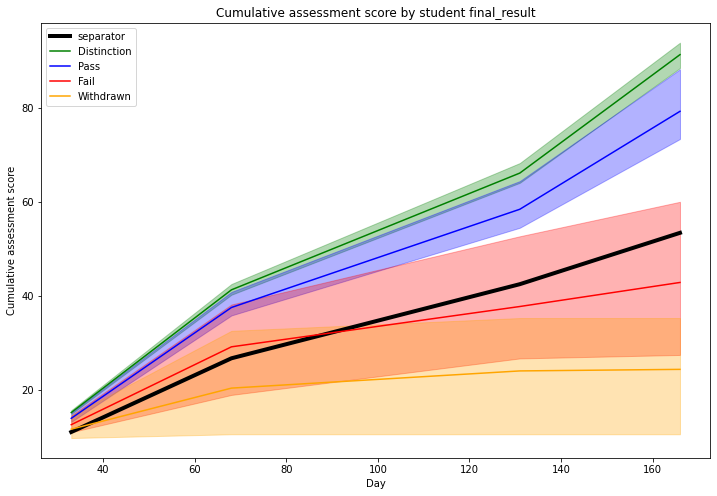

In [11]:
ax = splitting_values["separator"].plot(
    color="black",
    linewidth=4,
    figsize=(12, 8),
    title="Cumulative assessment score by student final_result",
    xlabel="Day",
    ylabel="Cumulative assessment score",
)

mean_and_quartiles = (
    cumulative_weighted_assessment_score.groupby("final_result")
    .agg(
        [
            ("mean", np.mean),
            ("first_quartile", lambda x: np.percentile(x, 25)),
            ("third_quartile", lambda x: np.percentile(x, 75)),
        ]
    )
    .T.reorder_levels(order=[1, 0])
    .unstack()
)


def fill_between_plot(label, color, values):
    """Plots a matplotlib `fill_between` plot in the given axis."""

    values["mean"].plot(ax=ax, color=color, label=label)
    args = [values.index, values.first_quartile, values.third_quartile]
    ax.fill_between(*args, color=color, alpha=0.3)


fill_between_plot("Distinction", "green", mean_and_quartiles["Distinction"].T)
fill_between_plot("Pass", "blue", mean_and_quartiles["Pass"].T)
fill_between_plot("Fail", "red", mean_and_quartiles["Fail"].T)
fill_between_plot("Withdrawn", "orange", mean_and_quartiles["Withdrawn"].T)
plt.legend()
plt.show()

Here too, we get similar graphs.
We note from this visualization that a clear distinction can be made between
`Distinction/Pass` and `Fail/Withdrawn` students if only considering the 25 and
75 percentile.

However, it might seem surprising why the splitting line is positioned that low.

Let's plot the same graph and replace the 25/75 percentiles with 0/100 (i.e., min/max)
percentiles.

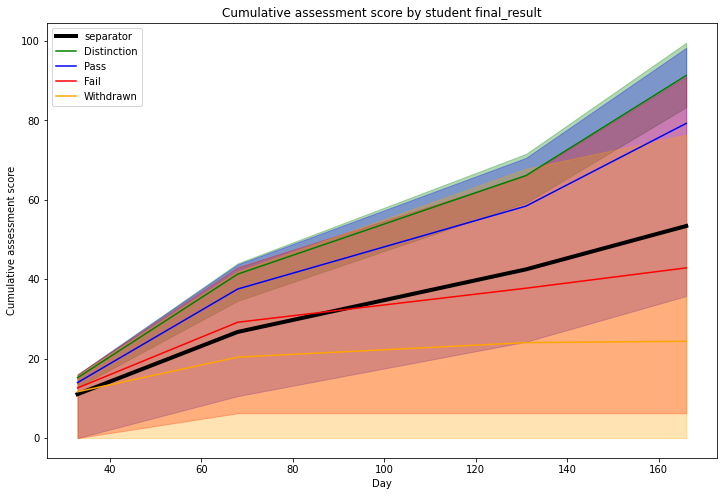

In [12]:
ax = splitting_values["separator"].plot(
    color="black",
    linewidth=4,
    figsize=(12, 8),
    title="Cumulative assessment score by student final_result",
    xlabel="Day",
    ylabel="Cumulative assessment score",
)

mean_and_quartiles = (
    cumulative_weighted_assessment_score.groupby("final_result")
    .agg(
        [
            ("mean", np.mean),
            ("first_quartile", lambda x: np.percentile(x, 0)),
            ("third_quartile", lambda x: np.percentile(x, 100)),
        ]
    )
    .T.reorder_levels(order=[1, 0])
    .unstack()
)

fill_between_plot("Distinction", "green", mean_and_quartiles["Distinction"].T)
fill_between_plot("Pass", "blue", mean_and_quartiles["Pass"].T)
fill_between_plot("Fail", "red", mean_and_quartiles["Fail"].T)
fill_between_plot("Withdrawn", "orange", mean_and_quartiles["Withdrawn"].T)
plt.legend()
plt.show()

We note that there is much more overlapping if considering the extremes.
This might explain why the splitting line was lower than expected previously, as it
tries to balance the tradeoff between passing students with a lower score and failing
students with a higher score.

## Cumulative number of clicks

We use the number of clicks in the VLE (Virtual Learning Environment) for the key
performance metric.

We follow the same steps as in the
[first example](#cumulative-weighted-assessments-scores).

### Step 1: Model the metric as a time series for each student

As in the work of Hlosta et al. we will use the `EEE/2014J` course.

```{note}
During merging, we loose 91 students that haven't interacted with the VLE.
```

In [13]:
cumulative_click_count = (
    oulad.student_registration[
        (oulad.student_registration.code_module == "EEE")
        & (oulad.student_registration.code_presentation == "2014J")
    ][["id_student"]]
    .merge(
        oulad.student_vle[
            (oulad.student_vle.code_module == "EEE")
            & (oulad.student_vle.code_presentation == "2014J")
        ][["id_student", "date", "sum_click"]],
        how="inner",
        on="id_student",
    )
    .groupby(["id_student", "date"])
    .agg(np.sum)
    .join(
        oulad.student_info[
            (oulad.student_info.code_module == "EEE")
            & (oulad.student_info.code_presentation == "2014J")
        ][["id_student", "final_result"]].set_index("id_student")
    )
    .set_index("final_result", append=True)
    .unstack(level=1)
    .fillna(0)
    .cumsum(axis=1)["sum_click"]
)
display(cumulative_click_count)

,date,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,...,260,261,262,263,264,265,266,267,268,269
id_student,final_result,,,,,,,,,,,,,,,,,,,,,
46048,Withdrawn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
47061,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,347.0,347.0,347.0,347.0,347.0,347.0,347.0,347.0,347.0,347.0
60809,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2422.0,2422.0,2422.0,2422.0,2422.0,2422.0,2422.0,2422.0,2422.0,2422.0
62034,Pass,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,...,1887.0,1887.0,1887.0,1887.0,1887.0,1889.0,1889.0,1889.0,1889.0,1889.0
67539,Pass,0.0,19.0,19.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,...,1437.0,1437.0,1437.0,1437.0,1437.0,1438.0,1438.0,1438.0,1438.0,1438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2654928,Pass,29.0,35.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,46.0,...,1784.0,1784.0,1784.0,1784.0,1784.0,1784.0,1785.0,1785.0,1785.0,1785.0
2663195,Pass,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1112.0,1112.0,1112.0,1112.0,1112.0,1112.0,1112.0,1112.0,1112.0,1112.0
2681277,Withdrawn,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,...,166.0,166.0,166.0,166.0,166.0,166.0,166.0,166.0,166.0,166.0


### Step 2: Perform statistical tests

As in the first example, let's first check whether we can use the Unpaired t-test.

#### Unpaired t-test

##### Assumptions

###### **Detecting extreme outliers statistically**

Let's verify whether there are any extreme outliers (above `Q3 + 3xIQR` or below
`Q1 - 3xIQR`).

In [14]:
extremes = (
    cumulative_click_count.quantile([0.25, 0.75])
    .T.assign(IQR=lambda x: x[0.75] - x[0.25])
    .assign(
        lower_extreme=lambda x: x[0.25] - 3 * x["IQR"],
        upper_extreme=lambda x: x[0.75] + 3 * x["IQR"],
    )[["lower_extreme", "upper_extreme"]]
)

bigger = cumulative_click_count > extremes.upper_extreme
smaller = cumulative_click_count < extremes.lower_extreme
total = bigger.sum().sum() + smaller.sum().sum()

print(
    f"The number of extreme outliers (N={total}) represents "
    f"{100 * total / cumulative_click_count.count().sum():.2f}"
    f"% of the dataset (N={cumulative_click_count.count().sum()})"
)

The number of extreme outliers (N=4330) represents 1.37% of the dataset (N=315936)


We note that the outliers ratio is more significant than in the previous example.
However, as the number of samples is much more prominent in this case, we also suppose
that the impact on the t-test will be limited.

###### **Examine normality**

We skip this step as the number of samples is high, and the central limit theorem
applies.

Thus, we assume here too that the normality requirement is satisfied.

###### **Verifying equal variances with the Levene test**

Finally, let's test the homogeneity of variance using the Levene test.

In [15]:
cumulative_click_count.agg(
    lambda x: levene(*[row[~np.isnan(row)] for row in x.unstack().T.values]).pvalue
    <= 0.05
).rename_axis("date").reset_index(0, drop=True).reset_index(name="H0 rejected")

,index,H0 rejected
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True
...,...,...
283,283,True
284,284,True
285,285,True
286,286,True


The Levene test indicates that there is evidence that the variances are **different**.

###### **Conclusion**

As in the first example, we conclude that assumptions for an Unpaired t-test are not
satisfied as the variances are different.

Therefore, we skip to the next test.

#### Wilcoxon rank-sum test

##### Assumptions

The dataset satisfies the Wilcoxon rank-sum test assumptions. We skip to the next
step.

##### Applying the test

We apply the Wilcoxon rank-sum test for each combination of `final_result` (e.g.,
Pass-Fail, Pass-Withdrawn, etc.) and for each time-slice (`date`) (-18, -17, etc.)

In [16]:
unstacked_cumulative_click_count = cumulative_click_count.unstack()
significance = np.zeros(
    (
        cumulative_click_count.index.levels[1].shape[0],
        unstacked_cumulative_click_count.shape[1],
    ),
    dtype=bool,
)

for offset, date in enumerate(cumulative_click_count):
    df = unstacked_cumulative_click_count[date]
    columns = df.columns
    offset *= len(columns)
    for i, j in combinations(range(len(columns)), r=2):
        significance[i, j + offset] = significance[j, i + offset] = (
            ranksums(df.iloc[:, i], df.iloc[:, j], nan_policy="omit").pvalue <= 0.05
        )

significance_df = (
    pd.DataFrame(
        significance,
        index=unstacked_cumulative_click_count.columns.levels[1],
        columns=unstacked_cumulative_click_count.T.index,
    )
    .rename_axis("")
    .rename_axis(["", "H0 rejected"], axis=1)
)

display(significance_df)

-18                                 -17                 \
H0 rejected Distinction   Fail   Pass Withdrawn Distinction   Fail   Pass   
                                                                            
Distinction       False   True   True      True       False   True   True   
Fail               True  False   True     False        True  False   True   
Pass               True   True  False     False        True   True  False   
Withdrawn          True  False  False     False        True  False   True   

                             -16          ...    267                   268  \
H0 rejected Withdrawn Distinction   Fail  ...   Pass Withdrawn Distinction   
                                          ...                                
Distinction      True       False   True  ...   True      True       False   
Fail            False        True  False  ...   True      True        True   
Pass             True        True   True  ...  False      True        True   
Withdrawn       False        True  False  ...   True     False        True   

                                            269                          
H0 rejected   Fail   Pass Withdrawn Distinction   Fail   Pass Withdrawn  
                                                                         
Distinction   True   True      True       False   True   True      True  
Fail         False   True      True        True  False   True      True  
Pass          True  False      True        True   True  False      True  
Withdrawn     True   True     False        True   True   True     False  

[4 rows x 1152 columns]

The hypothesis test indicates a significant difference in the variance between the
groups in the time slices, starting from the first time slice (from the day -18).

### Step 3: Compute the splitting value

As in the first example, in this step, we try to compute the splitting value in each
time slice that minimizes the split error between **Pass**ing students and **Fail**ing
students (counting "Distinction" also as "Passing" and "Withdrawn" as "Failing")

```{warning}
We are still working on this part! Our current implementation follows a
**naive** approach!
```

In [17]:
splitting_values = []

for date in cumulative_click_count.columns:
    df = cumulative_click_count[date]
    index = df.index.get_level_values(1).values
    index[index == "Distinction"] = "Pass"
    index[index == "Withdrawn"] = "Fail"

    unique_values = np.sort(df.unique())
    max_score = 0  # pylint: disable=invalid-name
    result = {}
    previous_value = np.NaN
    for value in unique_values:
        # Larger interval ==> more speed but less precision
        if value - previous_value < 100:
            continue
        previous_value = value
        separator = df < value
        # We suppose Fail score < Pass score
        score = (index[separator] == "Fail").sum() + (index[~separator] == "Pass").sum()
        if score > max_score:
            max_score = score
            result = {
                "score": round(max_score / cumulative_click_count.shape[0], 2),
                "separator": value,
            }

    splitting_values.append(result)

splitting_values = pd.DataFrame(splitting_values, index=cumulative_click_count.columns)
display(splitting_values)

,score,separator
date,,
-18,0.62,0.0
-17,0.62,0.0
-16,0.62,0.0
-15,0.62,0.0
-14,0.62,0.0
...,...,...
265,0.87,712.0
266,0.87,712.0
267,0.87,712.0


### Step 4: Plot the time-series graph

Finally, let's plot the results.

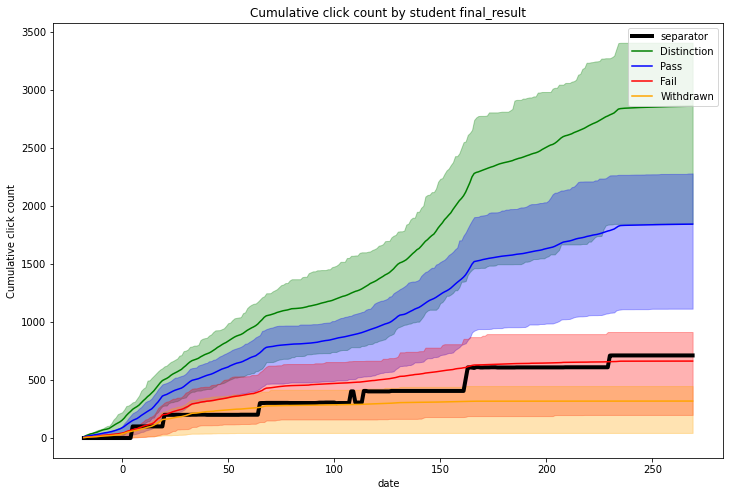

In [18]:
ax = splitting_values["separator"].plot(
    color="black",
    linewidth=4,
    figsize=(12, 8),
    title="Cumulative click count by student final_result",
    xlabel="Day",
    ylabel="Cumulative click count",
)

mean_and_quartiles = (
    cumulative_click_count.groupby("final_result")
    .agg(
        [
            ("mean", np.mean),
            ("first_quartile", lambda x: np.percentile(x, 25)),
            ("third_quartile", lambda x: np.percentile(x, 75)),
        ]
    )
    .T.reorder_levels(order=[1, 0])
    .unstack()
)

fill_between_plot("Distinction", "green", mean_and_quartiles["Distinction"].T)
fill_between_plot("Pass", "blue", mean_and_quartiles["Pass"].T)
fill_between_plot("Fail", "red", mean_and_quartiles["Fail"].T)
fill_between_plot("Withdrawn", "orange", mean_and_quartiles["Withdrawn"].T)
plt.legend()
plt.show()